In [2]:
from pyteomics import mzxml, auxiliary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import read_mzxml,psave,pload
import pickle
import uuid
import sys
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.rcParams['figure.figsize'] = (20, 6)
%matplotlib inline

# 读取mzxml

保留5位小数

In [3]:
df = read_mzxml("./data010.mzXML")
df = df.round(5).astype(np.float32)

In [4]:
irons = pload('irons.p')
mzs = pd.concat([irons.mz1,irons.mz2],axis=0).reset_index(drop=True).astype(np.float32)

In [5]:
mask_mas = np.any(abs(df.mz.values.reshape(-1,1)-mzs.values)<.1,axis=1)

In [6]:
df_origin = df.copy()
df = df.loc[mask_mas]

In [7]:
df_not = df_origin.loc[~mask_mas]

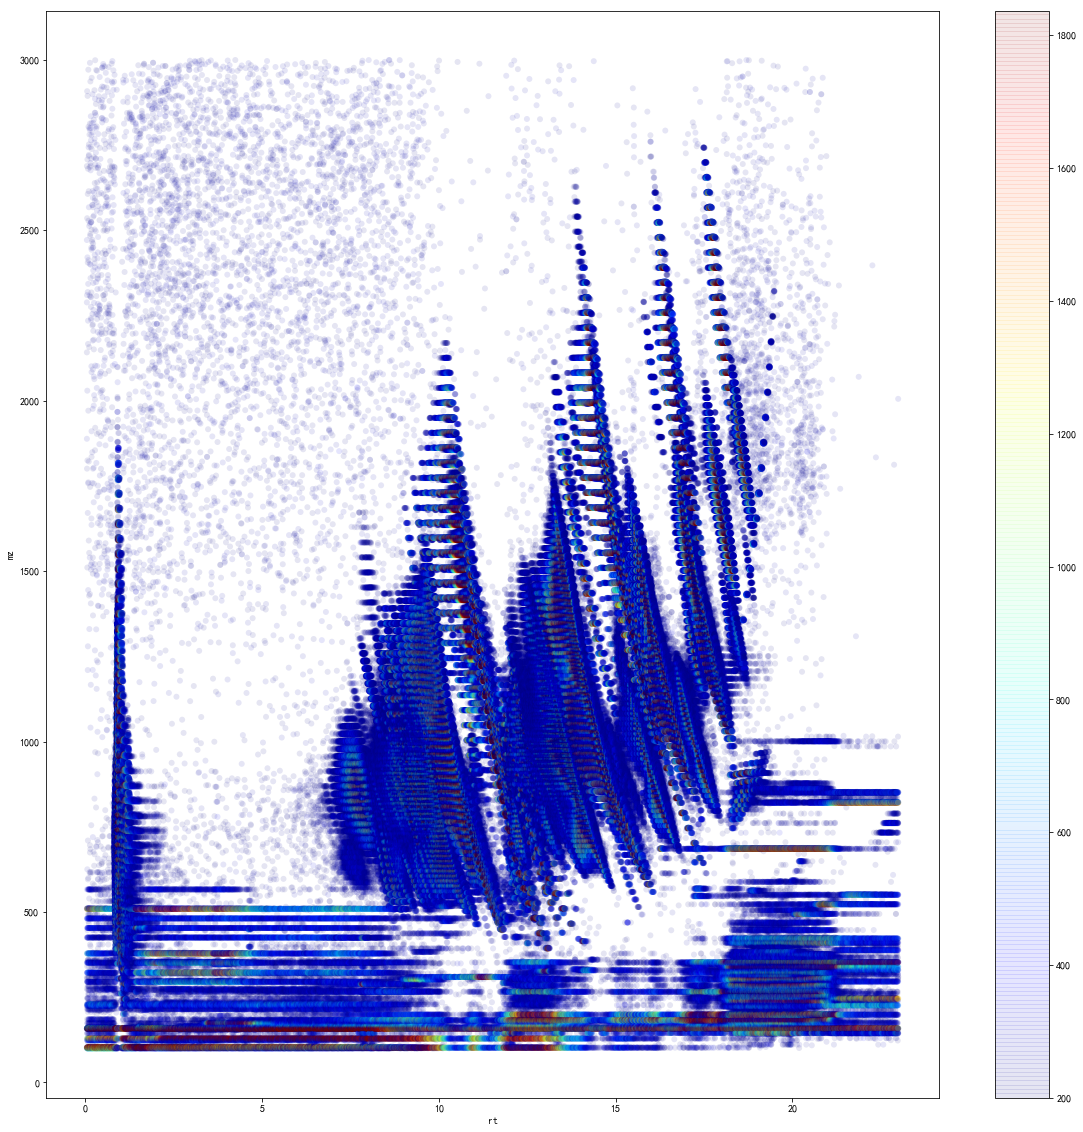

In [8]:
data = df_not
fig_name = 'mass-not.png'
vmax = np.percentile(data.intensity,90)
plt.rcParams['figure.figsize'] = (20,20)
plt.scatter(data.rt,data.mz,c=data.intensity,vmax=vmax,alpha=0.1, cmap="jet", edgecolors="none")
plt.xlabel('rt')
plt.ylabel('mz')
plt.savefig(fig_name,dpi = 300)
plt.colorbar()

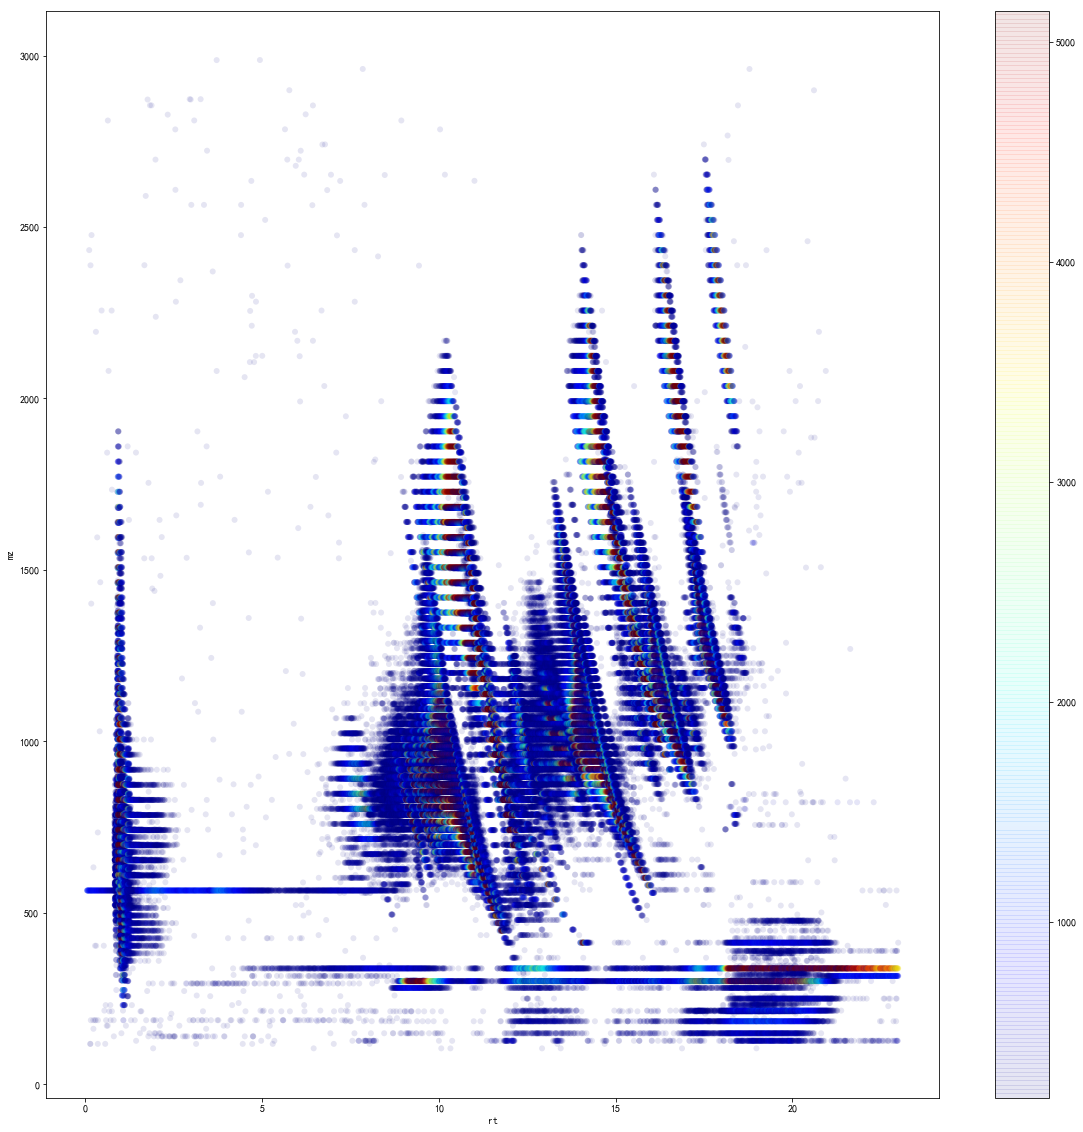

In [9]:
data = df
fig_name = 'mass-A-G.png'
vmax = np.percentile(data.intensity,90)
plt.rcParams['figure.figsize'] = (20,20)
plt.scatter(data.rt,data.mz,c=data.intensity,vmax=vmax,alpha=0.1, cmap="jet", edgecolors="none")
plt.xlabel('rt')
plt.ylabel('mz')
plt.colorbar()
plt.savefig(fig_name,dpi = 300)

# 保留时间校正
    mz = 1331.8279
    ppm = 1e-6
    error_threshold = mz*20*ppm
 1. 大范围取点。 rt范围：8.500-10.987min， mz范围：mz+-error_threshold
 2. 取各mz的EIC顶点(rt,intensity)
 3. 求各mz顶点强度intensity加权保留时间rt - rt_real

In [10]:
mzB = 1331.8279
ppm = 1e-6
error_threshold = 20*ppm
rtB = 10.91 #B组理论保留时间

In [11]:
def rt_real(df,rtrange=[8.500,10.987],mz=1331.8279,rt=10.91,et=20*ppm):
    #实测保留时间计算
    
    dfB = df.loc[df.rt.between(*rtrange)]#选取大范围的样本点
    dfB = dfB.loc[abs(dfB.mz-mz)<mz*et]#选取mzB
    grpB = dfB.groupby('mz')
    dfB1 = dfB.loc[grpB['intensity'].idxmax()]#eic顶点
    rtB_real = dfB1.rt.dot(dfB1.intensity/dfB1.intensity.sum())#顶点rt强度加权评价
    return rtB_real

In [12]:
def rt_correction(df,rtB,*args,**kwargs):
    delta = 1
    if abs(delta)>=.1:
        rtB_real = rt_real(df,*args,**kwargs)
        delta = rtB-rtB_real
        df['rt'] = df.rt+delta
        return df
    elif abs(delta)>=.5:
        raise "error"

In [13]:
df = rt_correction(df,rtB)

# 1级质谱离子库匹配

In [14]:
rts_range = pd.read_excel('./保留时间范围.xlsx',index_col=0)
rts_range

,峰匹配保留时间起点（min）,峰匹配保留时间终点（min）
组,,
A-1,0.500,1.500
A-2,0.500,1.500
B,9.121,11.774
C,8.515,12.379
D,12.752,16.028
E,10.850,16.850
F,15.016,18.359
G,16.525,19.325


In [15]:
dict1 = pd.read_excel('./各组理论离子峰信息-数值版(1)(1).xlsx',sheetname=None)

In [16]:
ds = []
for key in dict1.keys():
    d = pd.DataFrame(dict1[key])
    d['cat']=key
    ds.append(d)
irons = pd.concat(ds,axis=0)
irons.drop('保留时间RT/min',axis=1,inplace=True)
irons.columns=['cat','mz1','mz2','rt','n']
irons.reset_index(inplace=True)
irons.drop('index',axis=1,inplace=True)
psave(irons,'irons.p')

In [17]:
def avg_mass(mass, delta=.01, min_intensity=0):
    """
    平均色谱图
    :param mass: dataframe columns = ['mz','intensity','rt']
    :param delta:     离子峰容差 e.g .01 Da
    :param min_intensity: 最小峰强度
    :return: 平均色谱图
    """
    mass = mass.sort_values(by='mz')
    mass['cat'] = (mass.mz.diff() > delta).cumsum()
    group = mass.groupby('cat')
    mz = group.apply(lambda x: x.mz.dot(x.intensity / x.intensity.sum()))
    mz.name = 'mz'
    rt = group.apply(lambda x: x.rt.dot(x.intensity / x.intensity.sum()))
    rt.name = 'rt'
    intensity = group['intensity'].mean()
    avg = pd.concat([mz, intensity,rt], axis=1)
    min_mask = avg.intensity / avg.intensity.max() > min_intensity  # 小峰过滤
    avg = avg.loc[min_mask]
    return avg

In [18]:
def matchA(ironsi,avg,delta1 = 20*ppm):
    #匹配特征离子
    ironsi1_v = ironsi.mz1.values
    ironsi2_v = ironsi.mz2.values
    mzs = avg.mz.values
    r1 = abs(ironsi1_v-mzs.reshape(-1,1))<ironsi1_v*delta1
    r2 = abs(ironsi2_v-mzs.reshape(-1,1))<ironsi2_v*delta1
    r = r1|r2
    r1 = r.dot(ironsi.n)
    r2 = pd.Series(r1,index=avg.index)
    r2.loc[~r.any(axis=1)] = -9999
    avg.loc[:,'n']= r2
    return avg

In [19]:
def matchB_G(ironsi,avg,delta1 = 20*ppm,delta2=.01):
    ironsi1_v = ironsi.mz1.values
    ironsi2_v = ironsi.mz2.values
    ironsi_rtv = ironsi.rt.values
    mzs = avg.mz.values
    rts = avg.rt.values
    r1 = abs(ironsi1_v-mzs.reshape(-1,1))<ironsi1_v*delta1
    r2 = abs(ironsi2_v-mzs.reshape(-1,1))<ironsi2_v*delta1
    r3 = abs(ironsi_rtv-rts.reshape(-1,1))<ironsi_rtv*delta2#保留时间
    #r3 = abs(ironsi_rtv-rts.reshape(-1,1))<delta2#保留时间-绝对
    r = (r1|r2)&r3
    r1 = r.dot(ironsi.n)
    r2 = pd.Series(r1,index=avg.index)
    r2.loc[~r.any(axis=1)] = -9999
    avg.loc[:,'n']= r2
    return avg

In [20]:
def match(ironsi,avg,cat,delta1 = 20*ppm,delta2=.01):
    if cat in ['A-1','A-2']:
        return matchA(ironsi,avg,delta1)
    elif cat in ['B', 'C', 'D', 'E', 'F', 'G']:
        return matchB_G(ironsi,avg,delta1,delta2)
    else:
        raise('没有这个组！')

In [21]:
#match A
l = []
avgs = []
for cat in rts_range.index.tolist():
    idf =irons.loc[irons.cat ==cat]
    rtrange = rts_range.loc[cat]
    avg = avg_mass(df.loc[df.rt.between(*rtrange)])
    avg.loc[:,'grp'] = cat
    avgs.append(match(idf,avg,cat))
avg_dfs = pd.concat(avgs)
avg_dfs.loc[avg_dfs.n==-9999,'n']=np.nan

# 结果输出
excelwriter

In [40]:
out = avg_dfs.loc[~avg_dfs.n.isnull()].sort_values(['grp','n'])
out.columns = [u'm/z', u'intensity', u'保留时间(min)', u'组分名称', u'聚合度(n)']
out.loc[:,'intensity'] = out.intensity.astype(np.float64)
out.loc[:,u'聚合度(n)'] = out.loc[:,u'聚合度(n)'].astype(np.int)
out = out.round({u'm/z':4, u'intensity':2,u'保留时间(min)':3})
writer = pd.ExcelWriter('吐温80组成-rt绝对_A-G.xlsx', engine='xlsxwriter')
out.to_excel(writer,index=False,sheet_name='Sheet1')
workbook  = writer.book
worksheet = writer.sheets['Sheet1']
fig_position = out.reset_index(drop=True).groupby(u'组分名称')[u'聚合度(n)'].idxmin()+2
for grp in fig_position.index.tolist():
    worksheet.insert_image('F'+str(fig_position[grp]),grp+'.png')
writer.save()

In [39]:
e_out = out.copy()
e_out.columns = ['m/z (MS)','Intensity (MS)','Retention Time (min)','Group','Degree of Polymerization\
(n=w+x+y+z)']
e_out.loc[:,e_out.columns[1]] = e_out.iloc[:,1].astype(np.float64)
e_out.loc[:,e_out.columns[-1]] = e_out.loc[:,e_out.columns[-1]].astype(np.int)
e_out = e_out.round({e_out.columns[0]:4, e_out.columns[1]:2,e_out.columns[2]:3})
writer = pd.ExcelWriter('eng吐温80组成-rt绝对_A-G.xlsx', engine='xlsxwriter')
e_out.to_excel(writer,index=False,sheet_name='Sheet1')
workbook  = writer.book
worksheet = writer.sheets['Sheet1']
fig_position = e_out.reset_index(drop=True).groupby(e_out.columns[3])[e_out.columns[-1]].idxmin()+2
for grp in fig_position.index.tolist():
    worksheet.insert_image('F'+str(fig_position[grp]),grp+'.png')
writer.save()

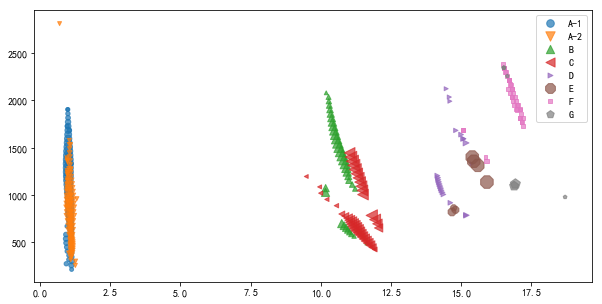

In [24]:
cmaps = iter(['Greys','Reds', 'Blues', 'Greens', 'Oranges', 'Purples',
            'cool', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn'])
filled_markers = iter(('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'))
for grp in out.组分名称.unique():
    d = out.loc[out.组分名称==grp]
    plt.rcParams['figure.figsize'] = (10,5)
    plt.scatter(d.loc[:,'保留时间(min)'].values,d.loc[:,'m/z'].values,
                cmap=next(cmaps),
                marker = next(filled_markers),
                s=np.sqrt(d.intensity),
                #s=d.intensity,
                label=grp,
                alpha =.7,
                edgecolors =None)
plt.legend()
plt.savefig('mass样品组分分布图1',dpi = 300)